# Importance of abstaining in the spouse problem

Here Snorkel is used for Information Extraction. 
<img src="imgs/sentence.jpg" width="700px;" onerror="this.onerror=null; this.src='/doks-theme/assets/images/sentence.jpg';" align="center" style="display: block; margin-left: auto; margin-right: auto;">

We want to classify each __candidate__ or pair of people mentioned in a sentence, as being married at some point or not.

In the above example, our candidate represents the possible relation `(Barack Obama, Michelle Obama)`. As readers, we know this mention is true due to external knowledge and the keyword of `wedding` occuring later in the sentence.

In [122]:
%matplotlib inline

import numpy as np
import pandas as pd
import random
from snorkel.labeling import LabelModel
from snorkel.analysis import metric_score
from snorkel.utils import probs_to_preds
from matplotlib import pyplot as plt
from tqdm import tqdm

Load pre-extracted label matrices on the training and dev set. The labeling functions applied to the datasets are called LFs.

In [2]:
Y_dev = np.load("spouse_y_dev.npy")
L_dev = np.load("spouse_l_dev.npy")
L_train = np.load("spouse_l_train.npy")

Load information about LFs

In [120]:
lf_summary = pd.read_csv("spouse_lf_summary.csv")
lf_summary

,Unnamed: 0,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,lf_husband_wife,0,[1],0.089648,0.036642,0.017432,93,159,0.369048
1,lf_husband_wife_left_window,1,[1],0.025258,0.021345,0.003557,30,41,0.422535
2,lf_same_last_name,2,[1],0.040555,0.016009,0.008538,19,95,0.166667
3,lf_married,3,[1],0.019210,0.006759,0.002490,22,32,0.407407
4,lf_familial_relationship,4,[0],0.115617,0.051939,0.026325,310,15,0.953846
5,lf_family_left_window,5,[0],0.041266,0.033440,0.007826,114,2,0.982759
6,lf_other_relationship,6,[0],0.013874,0.002846,0.002846,33,6,0.846154
7,lf_distant_supervision,7,[1],0.001067,0.001067,0.000000,2,1,0.666667
8,lf_distant_supervision_last_names,8,[1],0.001067,0.000711,0.000356,0,3,0.000000


In [6]:
lf_names = list(lf_summary[lf_summary.columns[0]])

### On how many samples all LFs abstain in the training and dev set?

In [30]:
def any_non_abstain(a):
    return np.any(a!=-1)
def all_abstain(a):
    return np.all(a==-1)

In [130]:
def print_performances(Y, probs, preds):
    print(
        f"F1: {metric_score(Y, preds=preds, metric='f1'):.3f}"
    )
    print(
        f"ROC-AUC: {metric_score(Y, probs=probs, metric='roc_auc'):.3f}"
    )

In [227]:
non_abstain_dev = np.apply_along_axis(any_non_abstain, 1, L_dev)
n_non_abstain_dev = np.count_nonzero(non_abstain_dev)
abstain_dev = ~non_abstain_dev
n_abstain_dev = np.count_nonzero(abstain_dev)
n_dev = L_dev.shape[0]
print(f"At least one LF does not abstain for {n_non_abstain_dev}/{n_dev} samples in the dev set")
print(f"Thus there are {n_abstain_dev} all-LF-abstaining samples in the dev set")

At least one LF does not abstain for 715/2811 samples in the dev set
Thus there are 2096 all-LF-abstaining samples in the dev set


In [131]:
n_dev = Y_dev.shape[0]
n_neg_dev = np.count_nonzero(Y_dev==0)
n_pos_neg = n_dev-n_neg_dev
prior_neg = n_neg_dev/n_dev
prior_pos = n_pos_neg/n_dev
print(f"Prior negative probability: {prior_neg:0.3f}")
print(f"Prior positive probability: {prior_pos:0.3f}")

Prior negative probability: 0.932
Prior positive probability: 0.068


In [228]:
non_abstain_train = np.apply_along_axis(any_non_abstain, 1, L_train)
n_non_abstain_train = np.count_nonzero(non_abstain_train)
abstain_train = ~non_abstain_train
n_abstain_train = np.count_nonzero(abstain_train)
n_train = L_train.shape[0]
print(f"At least one LF does not abstain for {n_non_abstain_train}/{n_train} samples in the training set")
print(f"Thus there are {n_abstain_train} all-LF-abstaining samples in the training set")

At least one LF does not abstain for 5734/22254 samples in the training set
Thus there are 16520 all-LF-abstaining samples in the training set


### Training the Label Model with increasing number of all-LF-abstaining samples

Start with the training set without all-LF-abstaining samples (the same used in the end Discriminant Model), then add more and more all-LF-abstaining samples.

In [20]:
non_abstain_idx_train = np.where(non_abstain_train)[0] 
L_train_non_abstain = L_train[non_abstain_idx_train,:]
n_lf = L_train_non_abstain.shape[1]

In [21]:
n_abstain_to_add = np.logspace(start=1, stop=4.7, num=30, base=10, dtype=np.int, endpoint=True)
n_abstain_to_add = np.concatenate([n_abstain_to_add, [0, n_abstain_train]])
n_abstain_to_add.sort()

In [22]:
n_abstain_to_add

array([    0,    10,    13,    17,    24,    32,    43,    58,    78,
         104,   140,   188,   253,   339,   455,   611,   819,  1099,
        1475,  1979,  2655,  3562,  4778,  6410,  8599, 11536, 15475,
       16520, 20760, 27850, 37360, 50118])

In [23]:
f1_abstain = []
roc_abstain = []

for n_abstain in tqdm(n_abstain_to_add):
    
    L_train_iter = np.append(L_train_non_abstain, -1*np.ones((n_abstain,n_lf)), axis=0)
    
    label_model_iter = LabelModel(cardinality=2, verbose=True)
    label_model_iter.fit(L_train_iter, Y_dev, n_epochs=5000, log_freq=500, seed=12345)
    
    probs_dev = label_model_iter.predict_proba(L_dev)
    preds_dev = probs_to_preds(probs_dev)
    
    f1 = metric_score(Y_dev, preds_dev, probs=probs_dev, metric='f1')
    roc = metric_score(Y_dev, preds_dev, probs=probs_dev, metric='roc_auc')
    
    f1_abstain.append(f1)
    roc_abstain.append(roc)  

100%|██████████| 32/32 [02:06<00:00,  3.96s/it]


Display performances versus the number of all-LF-abstaining samples added to the training set

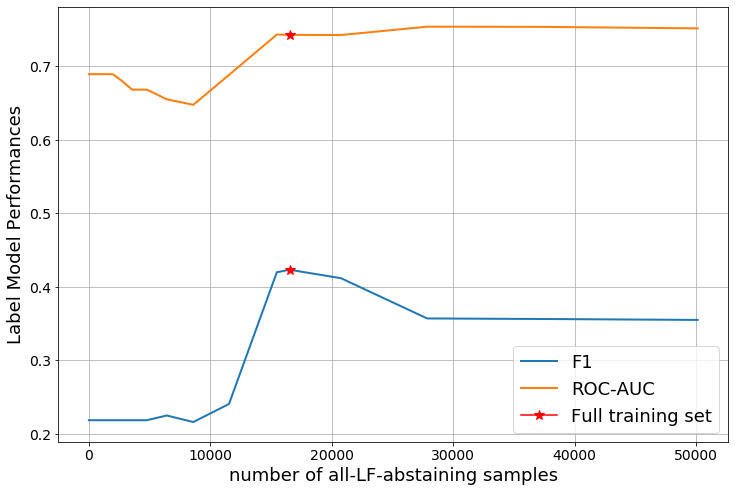

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(n_abstain_to_add, np.vstack([f1_abstain,roc_abstain]).T, linewidth=2)
plt.grid()
plt.ylabel("Label Model Performances", fontsize=18)
plt.xlabel("number of all-LF-abstaining samples", fontsize=18)
plt.tick_params(labelsize=14)

idx_full_train = np.where(np.array(n_abstain_to_add)==n_abstain_train)[0][0]
plt.plot(
    n_abstain_train, 
    np.vstack([f1_abstain[idx_full_train],roc_abstain[idx_full_train]]).T, 
    marker='*', color='red', markersize=10
)
plt.legend(['F1','ROC-AUC', 'Full training set'], fontsize=18)

At inference, the all-LF-abstaining samples are giving no information (conditional probability cancels out in the model), and only the priors are used for prediction. Let's check this for random samples in the extreme label model with 50000 all-LF-abstaining samples: 

In [45]:
abstain_dev = np.apply_along_axis(all_abstain, 1, L_dev)
n_abstain_dev = np.count_nonzero(abstain_dev)

idx_abstain_rel = random.randint(0, n_abstain_dev-1)
idx_abstain = np.where(abstain_dev)[0][idx_abstain_rel]

print("Random all-LF-abstaining samples in the dev set: ", idx_abstain)
print("LFs: ", L_dev[idx_abstain,:])
print("Class Probabilities:", probs_dev[idx_abstain,:])
print("Prediction: ", preds_dev[idx_abstain])

Random all-LF-abstaining samples in the dev set:  1951
LFs:  [-1 -1 -1 -1 -1 -1 -1 -1 -1]
Class Probabilities: [0.9324084 0.0675916]
Prediction:  0


### Train removing all-LF-abstaining samples with different n of epochs 

To be fair, the label models trained on smaller training sets actually need a smaller number of epoch, otherwise they'll overfit. Nevertheless the performance of the label model without all-LF-abstaining samples is inferior.

In [79]:
f1_abstain = []
roc_abstain = []
n_epochs_to_train = np.logspace(start=1, stop=3.3, num=50, base=10, dtype=np.int, endpoint=True)

for n_epochs in tqdm(n_epochs_to_train):
    
    label_model_iter = LabelModel(cardinality=2, verbose=True)
    label_model_iter.fit(L_train_non_abstain, Y_dev, n_epochs=n_epochs, log_freq=100, seed=12345)
    
    probs_dev = label_model_iter.predict_proba(L_dev)
    preds_dev = probs_to_preds(probs_dev)
    
    f1 = metric_score(Y_dev, preds_dev, probs=probs_dev, metric='f1')
    roc = metric_score(Y_dev, preds_dev, probs=probs_dev, metric='roc_auc')
    
    f1_abstain.append(f1)
    roc_abstain.append(roc) 

100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


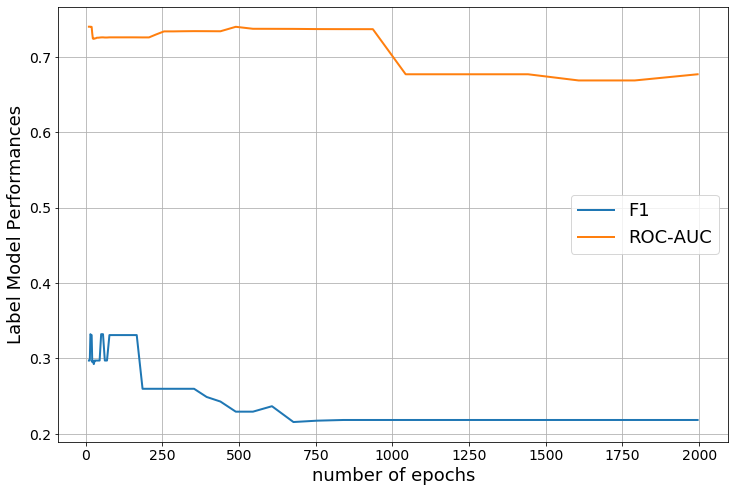

In [76]:
plt.figure(figsize=(12, 8))
plt.plot(n_epochs_to_train, np.vstack([f1_abstain,roc_abstain]).T, linewidth=2)
plt.legend(['F1','ROC-AUC'], fontsize=18)
plt.grid()
plt.ylabel("Label Model Performances", fontsize=18)
plt.xlabel("number of epochs", fontsize=18)
plt.tick_params(labelsize=14)

### What the regular and reduced models look like

Let's train the regular model on the whole training set

In [47]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, Y_dev, n_epochs=5000, log_freq=100, seed=12345)

In [134]:
probs_dev = label_model.predict_proba(L_dev)
preds_dev = probs_to_preds(probs_dev)
print("Label Model")
print_performances(Y_dev, probs_dev, preds_dev)

Label Model
F1: 0.423
ROC-AUC: 0.743


And now the reduced label model removing the all-LF-abstaining samples

In [113]:
label_model_reduced = LabelModel(cardinality=2, verbose=True)
label_model_reduced.fit(L_train_non_abstain, Y_dev, n_epochs=50, log_freq=100, seed=12345)

In [135]:
probs_dev_reduced = label_model_reduced.predict_proba(L_dev)
preds_dev_reduced = probs_to_preds(probs_dev_reduced)
print("Reduced Label Model")
print_performances(Y_dev, probs_dev_reduced, preds_dev_reduced)

Reduced Label Model
F1: 0.332
ROC-AUC: 0.726


Let's look at the conditional probabilities learned for each LF and that is used for prediction (along with the prior probabilities).
We can observe that for the regular model using all-LF-abstaining samples, the probability of ABSTAIN is much higher for all LFs, than in the reduced model. This means more uncertainty in the model, lowering the probability of predict any class, trusting more the priors only.

For each LF we have three lines, representing:
1. the ABSTAIN label Probability for the two classes: P(L=-1|Y=0), P(L=-1|Y=1)
2. the NEGATIVE label Probability for the two classes: P(L=0|Y=0), P(L=0|Y=1)
3. the POSITIVE label Probability for the two classes: P(L=1|Y=0), P(L=1|Y=1)


In [229]:
def print_conditional_probs(label_model, lf_names):
    np.set_printoptions('precision', 2, 'suppress', True)
    cond_probs = label_model.get_conditional_probs()
    cols = ["P(L|Y=0)", "P(L|Y=1)"]
    idx = ["ABSTAIN", "NEGATIVE", "POSITIVE"]
    for i in range(cond_probs.shape[0]):
        print(lf_names[i])
        df = pd.DataFrame(cond_probs[i,:,:], columns=cols, index=idx)
        print(df)
        print("")

Conditional Probabilities for the regular model:

In [231]:
print_conditional_probs(label_model, lf_names)

lf_husband_wife
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.952448   0.11374
NEGATIVE  0.000010   0.00001
POSITIVE  0.047542   0.88625

lf_husband_wife_left_window
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.990005  0.673467
NEGATIVE  0.000010  0.000010
POSITIVE  0.009985  0.326523

lf_same_last_name
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.966599  0.928895
NEGATIVE  0.000010  0.000010
POSITIVE  0.033391  0.071095

lf_married
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.984432  0.981276
NEGATIVE  0.000010  0.000010
POSITIVE  0.015558  0.018714

lf_familial_relationship
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.901186  0.843061
NEGATIVE  0.098804  0.156929
POSITIVE  0.000010  0.000010

lf_family_left_window
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.965697  0.942816
NEGATIVE  0.034293  0.057174
POSITIVE  0.000010  0.000010

lf_other_relationship
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.986027  0.994077
NEGATIVE  0.013963  0.005913
POSITIVE  0.000010  0.000010

lf_distant_supervision
          P(L|Y=

Conditional Probabilities for the reduced model:

In [230]:
print_conditional_probs(label_model_reduced, lf_names)

lf_husband_wife
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.695506  0.078668
NEGATIVE  0.000100  0.000100
POSITIVE  0.304394  0.921232

lf_husband_wife_left_window
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.938146  0.126888
NEGATIVE  0.000100  0.000100
POSITIVE  0.061754  0.873012

lf_same_last_name
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.938356   0.16949
NEGATIVE  0.000100   0.00010
POSITIVE  0.061544   0.83041

lf_married
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.985567  0.501208
NEGATIVE  0.000100  0.000100
POSITIVE  0.014333  0.498692

lf_familial_relationship
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.597342    0.9998
NEGATIVE  0.402558    0.0001
POSITIVE  0.000100    0.0001

lf_family_left_window
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.846721    0.9998
NEGATIVE  0.153179    0.0001
POSITIVE  0.000100    0.0001

lf_other_relationship
          P(L|Y=0)  P(L|Y=1)
ABSTAIN   0.955399  0.999156
NEGATIVE  0.044501  0.000744
POSITIVE  0.000100  0.000100

lf_distant_supervision
          P(L|Y=

### Generalization:  Training the End Model and check where all LF abstain in the test set

In [62]:
L_test = np.load("spouse_l_test.npy")
X_test = np.load("spouse_x_test.npy")
Y_test = np.load("spouse_y_test.npy")
probs_test = np.load("spouse_probs_test.npy")
preds_test = np.load("spouse_preds_test.npy")

In [138]:
print("End Model")
print_performances(Y_test, probs_test, preds_test)

End Model
F1: 0.467
ROC-AUC: 0.751


In [226]:
abstain_test = np.apply_along_axis(all_abstain, 1, L_test)
n_abstain_test = np.count_nonzero(abstain_test)
n_test = Y_test.shape[0]
print(f"There are {n_abstain_test}/{n_test} all-LF-abstaining samples in the test set\n")

X_test_abstain = X_test[abstain_test] 
X_test_non_abstain = X_test[~abstain_test]
Y_test_abstain = Y_test[abstain_test] 
Y_test_non_abstain = Y_test[~abstain_test]
probs_test_abstain = probs_test[abstain_test] 
probs_test_non_abstain = probs_test[~abstain_test]
preds_test_abstain = preds_test[abstain_test] 
preds_test_non_abstain = preds_test[~abstain_test]

n_abstain_correct = np.count_nonzero(Y_test_abstain==preds_test_abstain)
print(f"The end model correctly predicts {n_abstain_correct}/{n_abstain_test} samples where all LF abstain")

pos_idx = (Y_test_abstain==1)
n_abstain_correct_pos = np.count_nonzero(Y_test_abstain[pos_idx]==preds_test_abstain[pos_idx])
n_abstain_pos = np.count_nonzero(pos_idx)
print(f"The end model correctly predicts {n_abstain_correct_pos}/{n_abstain_pos} positive samples where all LF abstain")

print("\nEnd Model on all-LF-abstaining samples")
print_performances(Y_test_abstain, probs_test_abstain, preds_test_abstain)

print("\nEnd Model on non all-LF-abstaining samples")
print_performances(Y_test_non_abstain, probs_test_non_abstain, preds_test_non_abstain)

There are 1951/2701 all-LF-abstaining samples in the test set

The end model correctly predicts 1871/1951 samples where all LF abstain
The end model correctly predicts 1/58 positive samples where all LF abstain

End Model on all-LF-abstaining samples
F1: 0.024
ROC-AUC: 0.560

End Model on non all-LF-abstaining samples
F1: 0.544
ROC-AUC: 0.744


### Examples of samples where LF abstain and the end model predicted class

In [225]:
abstain_idx = random.randint(0, n_abstain_pos-1)

print("POSITIVE sentence" if Y_test_abstain[pos_idx][abstain_idx]==1 else "NEGATIVE sentence")
print(X_test_abstain[pos_idx][abstain_idx])
print("predicted as POSITIVE" if preds_test_abstain[pos_idx][abstain_idx]==1 else "predicted as NEGATIVE")

POSITIVE sentence
Thanks for your reaction Don’t forget to share this with your friends! 0 0 0 0 0 0   1 Rob Dyrdek and Bryiana Noelle got married on Sept. 19, and much like their over-the-top romance, their wedding looked lavish — and gorgeous!
predicted as NEGATIVE


## Summary
* In this umbalanced problem, the prior probabilities estimated from the dev set are essential and count for the 75% good predictions.
* The all-LF-abstaining samples in the training set are useful to learn a model that trust less the LFs and relies more on the prior probabilities.
* Artificially adding all-LF-abstaining samples in the training set, learns a model that only relies on the priors (conditional probabilities for the LFs tend to zero for both classes).
* Generalization of the end model is also bad for the positive samples